<a href="https://colab.research.google.com/github/Alan-Cheong/IEEE_QW_2020/blob/master/US_Trade_Tariffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Initial Tariffs (Year 0, Quarter 0) ---

--- Simulating Year 1, Quarter 1 ---

--- Simulating Year 1, Quarter 2 ---

--- Simulating Year 1, Quarter 3 ---

--- Simulating Year 1, Quarter 4 ---

--- Simulating Year 2, Quarter 1 ---

--- Simulating Year 2, Quarter 2 ---

--- Simulating Year 2, Quarter 3 ---

--- Simulating Year 2, Quarter 4 ---

--- Simulating Year 3, Quarter 1 ---

--- Simulating Year 3, Quarter 2 ---

--- Simulating Year 3, Quarter 3 ---

--- Simulating Year 3, Quarter 4 ---

--- Tariffs after 3 Years (12 Quarters) ---
                              Country  Initial Tariff (%)  Final Tariff (%)  Change (%)
38                    Myanmar (Burma)                  44              64.1        20.1
113                            Guyana                  38              19.7       -18.3
100                           Algeria                  30              13.8       -16.2
41                             Serbia                  37              21.9       -15.1
3              

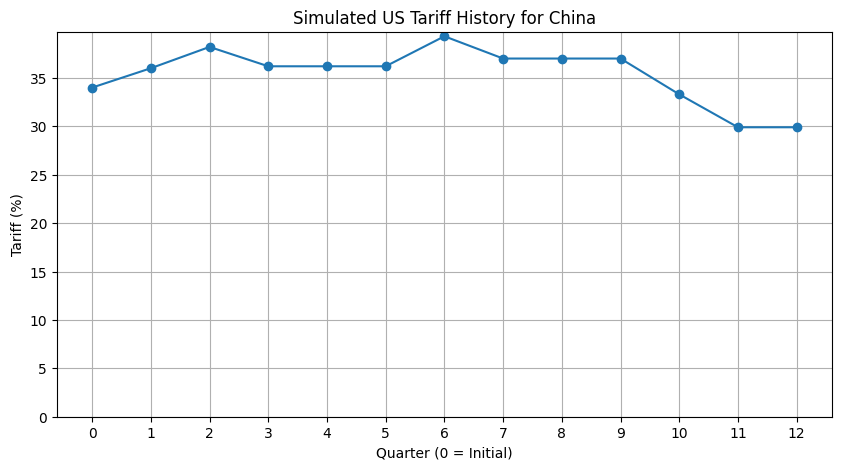

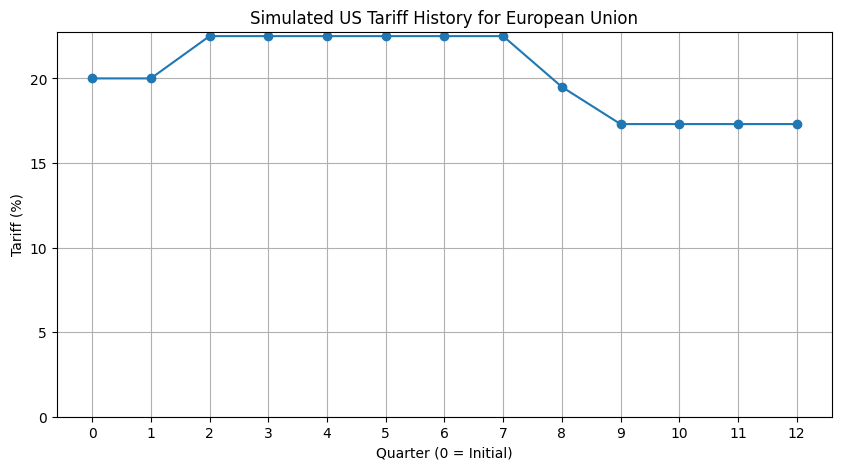

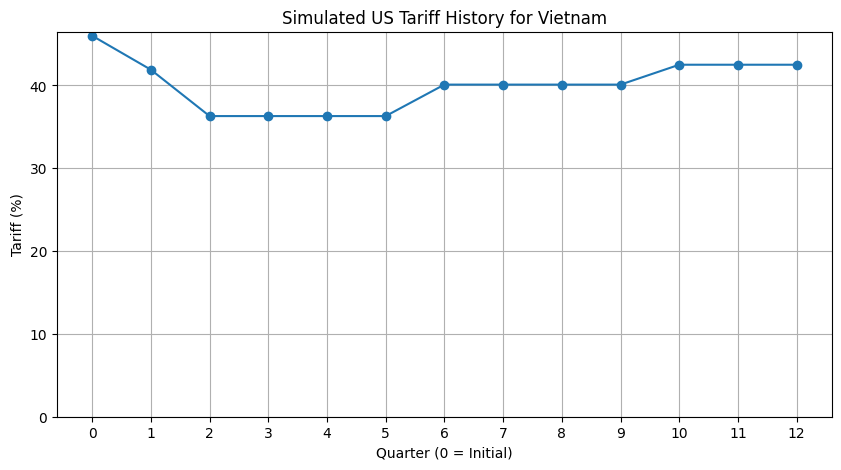

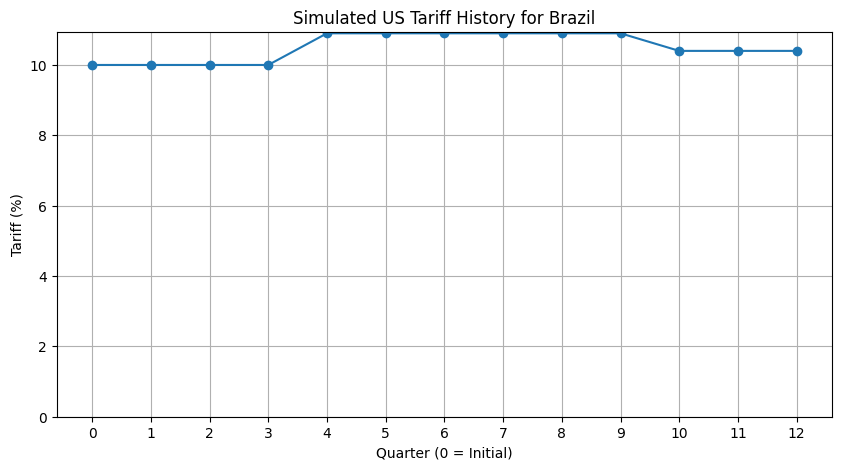

--- Simulation Results ---
                              Country  Initial Tariff (%)  Final Tariff (%)  Change (%)
38                    Myanmar (Burma)                  44              64.1        20.1
113                            Guyana                  38              19.7       -18.3
100                           Algeria                  30              13.8       -16.2
41                             Serbia                  37              21.9       -15.1
3                              Taiwan                  32              18.9       -13.1
7                            Thailand                  36              23.8       -12.2
37                         Madagascar                  47              36.2       -10.8
4                               Japan                  24              13.4       -10.6
39                            Tunisia                  28              18.0       -10.0
126                            Angola                  32              22.7        -9.3
5    

In [ ]:
!pip install openpyxl
import random
import copy
import pandas as pd
import io

# 1. Initial Tariff Data (Copied from the image description)
# Using Pandas to easily read the data structure provided implicitly
# (Simulating reading the table data)

data_text = """
Country,U.S.A. Discounted Reciprocal Tariffs (%)
China,34
European Union,20
Vietnam,46
Taiwan,32
Japan,24
India,26
South Korea,25
Thailand,36
Switzerland,31
Indonesia,32
Malaysia,24
Cambodia,49
United Kingdom,10
South Africa,30
Brazil,10
Bangladesh,37
Singapore,10
Israel,17
Philippines,17
Chile,10
Australia,10
Pakistan,29
Turkey,10
Sri Lanka,44
Colombia,10
Peru,10
Nicaragua,18
Norway,15
Costa Rica,10
Jordan,20
Dominican Republic,10
United Arab Emirates,10
New Zealand,10
Argentina,10
Ecuador,10
Guatemala,10
Honduras,10
Madagascar,47
Myanmar (Burma),44
Tunisia,28
Kazakhstan,27
Serbia,37
Egypt,10
Saudi Arabia,10
El Salvador,10
Côte d'Ivoire,21
Laos,48
Botswana,37
Trinidad and Tobago,10
Morocco,10
Papua New Guinea,10
Malawi,17
Liberia,10
British Virgin Islands,10
Afghanistan,10
Zimbabwe,18
Benin,10
Barbados,10
Monaco,10
Syria,41
Uzbekistan,10
Republic of the Congo,10
Djibouti,10
French Polynesia,10
Cayman Islands,10
Kosovo,10
Curaçao,10
Vanuatu,22
Rwanda,10
Sierra Leone,10
Mongolia,10
San Marino,10
Antigua and Barbuda,10
Bermuda,10
Eswatini,10
Marshall Islands,10
Saint Pierre and Miquelon,50
Saint Kitts and Nevis,10
Turkmenistan,10
Grenada,10
Sudan,10
Turks and Caicos Islands,10
Aruba,10
Montenegro,10
Saint Helena,10
Kyrgyzstan,10
Yemen,10
Saint Vincent and the Grenadines,10
Niger,10
Saint Lucia,10
Nauru,30
Equatorial Guinea,13
Iran,10
Libya,31
Samoa,10
Guinea,10
Timor-Leste,10
Montserrat,10
Chad,13
Mali,10
Algeria,30
Oman,10
Uruguay,10
Bahamas,10
Lesotho,50
Ukraine,10
Bahrain,10
Qatar,10
Mauritius,40
Fiji,32
Iceland,10
Kenya,10
Liechtenstein,37
Guyana,38
Haiti,10
Bosnia and Herzegovina,35
Nigeria,14
Namibia,21
Brunei,24
Bolivia,10
Panama,10
Venezuela,15
North Macedonia,33
Ethiopia,10
Ghana,10
Moldova,31
Angola,32
Democratic Republic of the Congo,11
Jamaica,10
Mozambique,16
Paraguay,10
Zambia,17
Lebanon,10
Tanzania,10
Iraq,39
Georgia,10
Senegal,10
Azerbaijan,10
Cameroon,11
Uganda,10
Albania,10
Armenia,10
Nepal,10
Sint Maarten,10
Falkland Islands,41
Gabon,10
Kuwait,10
Togo,10
Suriname,10
Belize,10
Maldives,10
Tajikistan,10
Cabo Verde,10
Burundi,10
Guadeloupe,10
Bhutan,10
Martinique,10
Tonga,10
Mauritania,10
Dominica,10
Micronesia,10
Gambia,10
French Guiana,10
Christmas Island,10
Andorra,10
Central African Republic,10
Solomon Islands,10
Mayotte,10
Anguilla,10
Cocos (Keeling) Islands,10
Eritrea,10
Cook Islands,10
South Sudan,10
Comoros,10
Kiribati,10
Sao Tome and Principe,10
Norfolk Island,29
Gibraltar,10
Tuvalu,10
British Indian Ocean Territory,10
Tokelau,10
Guinea-Bissau,10
Svalbard and Jan Mayen,10
Heard and McDonald Islands,10
Reunion,37
"""

# Use StringIO to simulate reading from a file or buffer
data_io = io.StringIO(data_text)
df = pd.read_csv(data_io)

# Convert to dictionary {Country: Tariff}
initial_tariffs = df.set_index('Country')['U.S.A. Discounted Reciprocal Tariffs (%)'].to_dict()

# --- Simulation Parameters ---
N_YEARS = 3
PERIODS_PER_YEAR = 4 # Quarterly simulation
N_PERIODS = N_YEARS * PERIODS_PER_YEAR
MIN_TARIFF = 5 # Define a floor for tariffs, maybe representing a base MFN rate
HIGH_TARIFF_THRESHOLD = 15 # Tariffs above this are considered 'high'

# Probabilities (can be tuned)
# -- Country Stance Probabilities (based on current US tariff) --
# If tariff is HIGH
PROB_NEGOTIATE_IF_HIGH = 0.50
PROB_RETALIATE_IF_HIGH = 0.35
# PROB_ACCEPT_IF_HIGH = 1.0 - PROB_NEGOTIATE_IF_HIGH - PROB_RETALIATE_IF_HIGH = 0.15

# If tariff is LOW (<= HIGH_TARIFF_THRESHOLD)
PROB_ACCEPT_IF_LOW = 0.75
PROB_NEGOTIATE_IF_LOW = 0.20
# PROB_RETALIATE_IF_LOW = 1.0 - PROB_ACCEPT_IF_LOW - PROB_NEGOTIATE_IF_LOW = 0.05

# -- US Response Probabilities (based on country stance) --
# If country Accepts
PROB_US_MAINTAIN_IF_ACCEPT = 0.95
# PROB_US_DECREASE_IF_ACCEPT = 1.0 - PROB_US_MAINTAIN_IF_ACCEPT = 0.05 (minor goodwill decrease)

# If country Negotiates
PROB_US_DECREASE_IF_NEGOTIATE = 0.40 # Chance of successful negotiation
PROB_US_MAINTAIN_IF_NEGOTIATE = 0.60 # Chance negotiation fails/stalls

# If country Retaliates
PROB_US_MAINTAIN_IF_RETALIATE = 0.60 # Hold firm
PROB_US_INCREASE_IF_RETALIATE = 0.25 # Escalate
PROB_US_DECREASE_IF_RETALIATE = 0.15 # Back down slightly due to cost of retaliation

# Tariff Adjustment Factors (how much tariffs change)
DECREASE_FACTOR_NEGOTIATE = (0.85, 0.95) # Decrease to 85-95% of current value
DECREASE_FACTOR_GOODWILL = (0.95, 0.99) # Small decrease
DECREASE_FACTOR_RETALIATE = (0.90, 0.98) # Small decrease due to cost
INCREASE_FACTOR_RETALIATE = (1.05, 1.15) # Increase by 5-15%

# --- Simulation Setup ---
current_tariffs = copy.deepcopy(initial_tariffs)
history = {country: [tariff] for country, tariff in initial_tariffs.items()}

print(f"--- Initial Tariffs (Year 0, Quarter 0) ---")
# Optionally print initial state here if desired (can be long)
# for country, tariff in initial_tariffs.items():
#     print(f"{country}: {tariff}%")

# --- Simulation Loop ---
for period in range(1, N_PERIODS + 1):
    year = (period - 1) // PERIODS_PER_YEAR + 1
    quarter = (period - 1) % PERIODS_PER_YEAR + 1
    print(f"\n--- Simulating Year {year}, Quarter {quarter} ---")

    next_tariffs = copy.deepcopy(current_tariffs) # Work on a copy for this period's changes

    for country, tariff in current_tariffs.items():
        # 1. Determine Country Stance (based on current tariff)
        rand_stance = random.random()
        country_stance = "Unknown"

        if tariff > HIGH_TARIFF_THRESHOLD:
            if rand_stance < PROB_NEGOTIATE_IF_HIGH:
                country_stance = "Negotiate"
            elif rand_stance < PROB_NEGOTIATE_IF_HIGH + PROB_RETALIATE_IF_HIGH:
                country_stance = "Retaliate"
            else:
                country_stance = "Accept"
        else: # Tariff is low
             if rand_stance < PROB_ACCEPT_IF_LOW:
                country_stance = "Accept"
             elif rand_stance < PROB_ACCEPT_IF_LOW + PROB_NEGOTIATE_IF_LOW:
                country_stance = "Negotiate"
             else:
                country_stance = "Retaliate"

        # 2. Determine US Action (based on country stance)
        rand_action = random.random()
        us_action = "Maintain"
        new_tariff = tariff # Start with current tariff

        if country_stance == "Accept":
            if rand_action > PROB_US_MAINTAIN_IF_ACCEPT: # Small chance of goodwill decrease
               us_action = "Decrease (Goodwill)"
               decrease_mult = random.uniform(*DECREASE_FACTOR_GOODWILL)
               new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))

        elif country_stance == "Negotiate":
            if rand_action < PROB_US_DECREASE_IF_NEGOTIATE:
                us_action = "Decrease (Negotiated)"
                decrease_mult = random.uniform(*DECREASE_FACTOR_NEGOTIATE)
                new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))
            # Else: Maintain (Negotiation Failed)

        elif country_stance == "Retaliate":
            if rand_action < PROB_US_MAINTAIN_IF_RETALIATE:
                us_action = "Maintain (Holding Firm)"
            elif rand_action < PROB_US_MAINTAIN_IF_RETALIATE + PROB_US_INCREASE_IF_RETALIATE:
                us_action = "Increase (Escalate)"
                increase_mult = random.uniform(*INCREASE_FACTOR_RETALIATE)
                # No upper bound specified, could add one if needed
                new_tariff = round(tariff * increase_mult, 1)
            else:
                us_action = "Decrease (Cost of Retaliation)"
                decrease_mult = random.uniform(*DECREASE_FACTOR_RETALIATE)
                new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))

        # Update tariff for the *next* period
        next_tariffs[country] = new_tariff
        history[country].append(new_tariff) # Store history

        # Optional: Print detailed changes per country per period (can be verbose)
        # if tariff != new_tariff:
        #     print(f"  {country}: Current={tariff}%, Stance={country_stance}, US Action={us_action}, New={new_tariff}%")
        # else:
        #     print(f"  {country}: Current={tariff}%, Stance={country_stance}, US Action=Maintain")


    # Update the current state for the next iteration
    current_tariffs = next_tariffs

# --- Final Results ---
print(f"\n--- Tariffs after {N_YEARS} Years ({N_PERIODS} Quarters) ---")

results_df = pd.DataFrame({
    'Country': list(initial_tariffs.keys()),
    'Initial Tariff (%)': list(initial_tariffs.values()),
    'Final Tariff (%)': [current_tariffs[country] for country in initial_tariffs.keys()]
})
results_df['Change (%)'] = results_df['Final Tariff (%)'] - results_df['Initial Tariff (%)']
results_df['Change (Abs)'] = results_df['Change (%)'].abs() # For sorting

# Sort by magnitude of change for better overview
results_df_sorted = results_df.sort_values(by='Change (Abs)', ascending=False).drop(columns=['Change (Abs)'])


print(results_df_sorted.to_string()) # Use to_string to print entire dataframe

# Optional: Plot history for a specific country (requires matplotlib)
try:
    import matplotlib.pyplot as plt

    def plot_tariff_history(country_name):
        if country_name in history:
            periods = range(N_PERIODS + 1)
            tariffs = history[country_name]
            plt.figure(figsize=(10, 5))
            plt.plot(periods, tariffs, marker='o', linestyle='-')
            plt.title(f"Simulated US Tariff History for {country_name}")
            plt.xlabel("Quarter (0 = Initial)")
            plt.ylabel("Tariff (%)")
            plt.xticks(periods)
            plt.grid(True)
            plt.ylim(bottom=0) # Ensure y-axis starts at 0
            plt.show()
        else:
            print(f"Country '{country_name}' not found in data.")

    # Example plots:
    plot_tariff_history("China")
    plot_tariff_history("European Union")
    plot_tariff_history("Vietnam") # High initial tariff
    plot_tariff_history("Brazil")   # Low initial tariff

except ImportError:
    print("\nMatplotlib not found. Cannot generate plots. Install with: pip install matplotlib")


#print("--- Simulation Results ---")
#print(results_df_sorted.to_string())

# --- Save to Excel ---
#excel_filename = "tariff_simulation_results.xlsx"
#sheet_name = "Simulation Results"

#try:
    # Use the DataFrame's to_excel method
#    results_df_sorted.to_excel(excel_filename, index=False, sheet_name=sheet_name)
#    print(f"\nResults successfully saved to '{excel_filename}' (Sheet: '{sheet_name}')")
#    print(f"Look for this file in the same directory where you ran the Python script.")

#except ImportError:
#    print(f"\nError: Could not save to Excel.")
#    print(f"The 'openpyxl' library is required. Please install it using:")
#    print(f"  pip install openpyxl")
#except PermissionError:
#    print(f"\nError: Could not save to '{excel_filename}'.")
#    print(f"Permission denied. Make sure the file is not open in Excel and you have write permissions in the directory.")
#except Exception as e:
#    print(f"\nAn unexpected error occurred while saving to Excel: {e}")


print("--- Simulation Results ---")
print(results_df_sorted.to_string())

# --- Save to Excel ---
import os # Import the os module

# --- Define the specific output directory and filename ---
output_directory = r"C:\Users\alan.cheong\Desktop\Research Paper\Coding" # Use raw string for path
base_filename = "tariff_simulation_results.xlsx"
excel_filepath = os.path.join(output_directory, base_filename) # Combine directory and filename
# --- End of definition ---

sheet_name = "Simulation Results"

try:
    # --- Create the directory if it doesn't exist ---
    # os.makedirs ensures that the directory path exists.
    # exist_ok=True prevents an error if the directory already exists.
    os.makedirs(output_directory, exist_ok=True)
    # --- End of directory creation ---

    # Use the full excel_filepath variable here
    results_df_sorted.to_excel(excel_filepath, index=False, sheet_name=sheet_name)

    # Update the confirmation message to show the full path
    print(f"\nResults successfully saved to '{excel_filepath}' (Sheet: '{sheet_name}')")

except ImportError:
    print(f"\nError: Could not save to Excel.")
    print(f"The 'openpyxl' library is required. Please install it using:")
    print(f"  pip install openpyxl")
except PermissionError:
    # Update the error message
    print(f"\nError: Could not save to '{excel_filepath}'.")
    print(f"Permission denied. Make sure the directory exists, you have write permissions, and the file is not open.")
except OSError as e:
    # Catch potential OS errors during directory creation or saving
    print(f"\nAn OS error occurred while trying to save to '{excel_filepath}': {e}")
except Exception as e:
    # Update the error message
    print(f"\nAn unexpected error occurred while saving to '{excel_filepath}': {e}")

--- Initial Tariffs (Year 0, Quarter 0) ---

--- Simulating Year 1, Quarter 1 ---

--- Simulating Year 1, Quarter 2 ---

--- Simulating Year 1, Quarter 3 ---

--- Simulating Year 1, Quarter 4 ---

--- Simulating Year 2, Quarter 1 ---

--- Simulating Year 2, Quarter 2 ---

--- Simulating Year 2, Quarter 3 ---

--- Simulating Year 2, Quarter 4 ---

--- Simulating Year 3, Quarter 1 ---

--- Simulating Year 3, Quarter 2 ---

--- Simulating Year 3, Quarter 3 ---

--- Simulating Year 3, Quarter 4 ---

--- Tariffs after 3 Years (12 Quarters) ---
                              Country  Initial Tariff (%)  Final Tariff (%)  Change (%)
35                              China                 125             110.7       -14.3
166                             Tonga                  10               1.7        -8.3
156            Svalbard and Jan Mayen                  10               1.8        -8.2
19                             Bhutan                  10               2.0        -8.0
168            

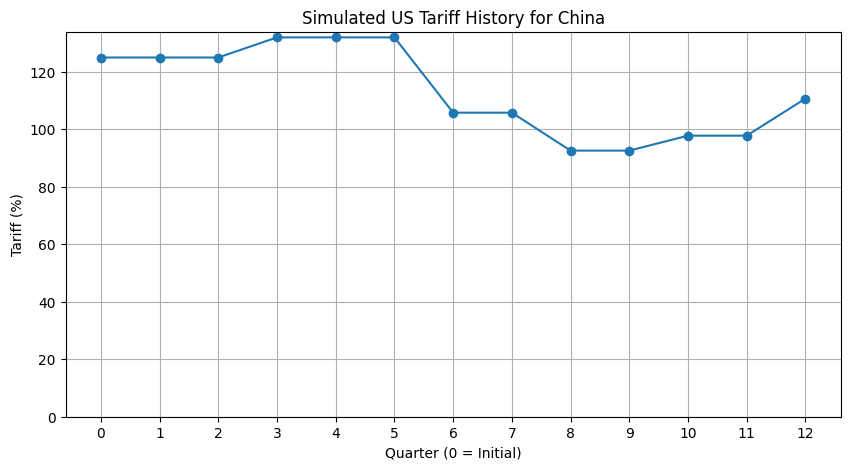

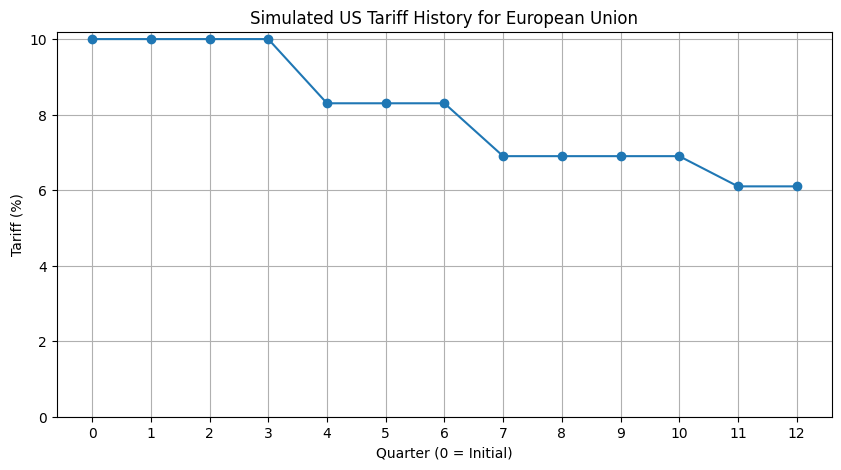

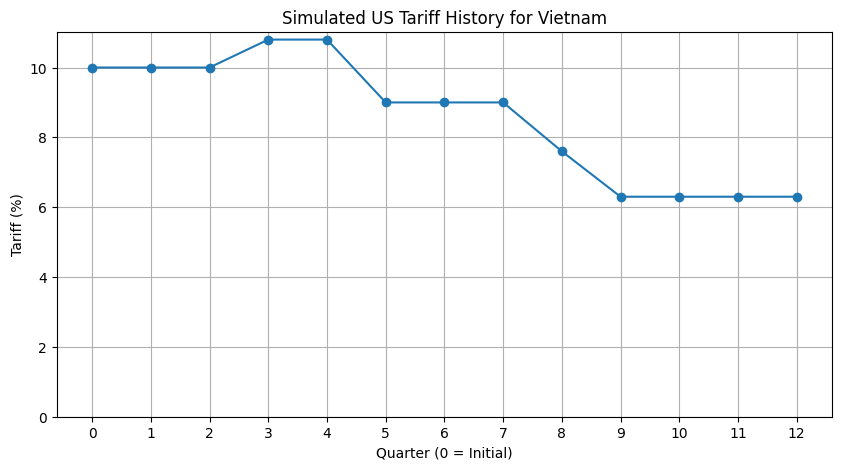

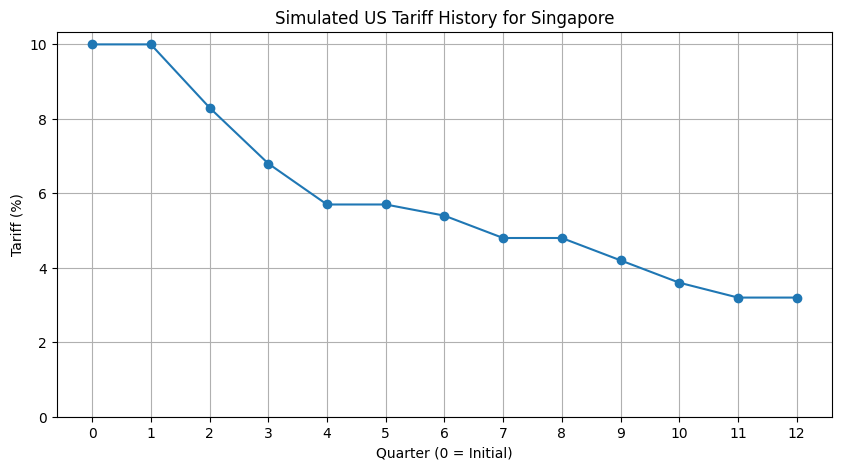

--- Simulation Results ---
                              Country  Initial Tariff (%)  Final Tariff (%)  Change (%)
35                              China                 125             110.7       -14.3
166                             Tonga                  10               1.7        -8.3
156            Svalbard and Jan Mayen                  10               1.8        -8.2
19                             Bhutan                  10               2.0        -8.0
168                           Tunisia                  10               2.2        -7.8
110                        Montserrat                  10               2.3        -7.7
129                              Peru                  10               2.3        -7.7
177                           Uruguay                  10               2.4        -7.6
7                           Argentina                  10               2.5        -7.5
103                         Mauritius                  10               2.5        -7.5
154  

In [10]:
!pip install openpyxl
import random
import copy
import pandas as pd
import io

# 1. Initial Tariff Data (Copied from the image description)
# Using Pandas to easily read the data structure provided implicitly
# (Simulating reading the table data)

data_text = """
Country,U.S.A. Discounted Reciprocal Tariffs (%)
Afghanistan, 10
Albania, 10
Algeria, 10
Andorra, 10
Angola, 10
Anguilla, 10
Antigua and Barbuda, 10
Argentina, 10
Armenia, 10
Aruba, 10
Australia, 10
Azerbaijan, 10
Bahamas, 10
Bahrain, 10
Bangladesh, 10
Barbados, 10
Belize, 10
Benin, 10
Bermuda, 10
Bhutan, 10
Bolivia, 10
Bosnia and Herzegovina, 10
Botswana, 10
Brazil, 10
British Indian Ocean Territory, 10
British Virgin Islands, 10
Brunei, 10
Burundi, 10
Cabo Verde, 10
Cambodia, 10
Cameroon, 10
Cayman Islands, 10
Central African Republic, 10
Chad, 10
Chile, 10
China, 125
Christmas Island, 10
Cocos (Keeling) Islands, 10
Colombia, 10
Comoros, 10
Cook Islands, 10
Costa Rica, 10
Côte d’Ivoire, 10
Curaçao, 10
Democratic Republic of the Congo, 10
Djibouti, 10
Dominica, 10
Dominican Republic, 10
Ecuador, 10
Egypt, 10
El Salvador, 10
Equatorial Guinea, 10
Eritrea, 10
Eswatini, 10
Ethiopia, 10
European Union, 10
Falkland Islands, 10
Fiji, 10
French Guiana, 10
French Polynesia, 10
Gabon, 10
Gambia, 10
Georgia, 10
Ghana, 10
Gibraltar, 10
Grenada, 10
Guadeloupe, 10
Guatemala, 10
Guinea, 10
Guinea-Bissau, 10
Guyana, 10
Haiti, 10
Heard and McDonald Islands, 10
Honduras, 10
Iceland, 10
India, 10
Indonesia, 10
Iran, 10
Iraq, 10
Israel, 10
Jamaica, 10
Japan, 10
Jordan, 10
Kazakhstan, 10
Kenya, 10
Kiribati, 10
Kosovo, 10
Kuwait, 10
Kyrgyzstan, 10
Laos, 10
Lebanon, 10
Lesotho, 10
Liberia, 10
Libya, 10
Liechtenstein, 10
Madagascar, 10
Malawi, 10
Malaysia, 10
Maldives, 10
Mali, 10
Marshall Islands, 10
Martinique, 10
Mauritania, 10
Mauritius, 10
Mayotte, 10
Micronesia, 10
Moldova, 10
Monaco, 10
Mongolia, 10
Montenegro, 10
Montserrat, 10
Morocco, 10
Mozambique, 10
Myanmar, 10
Namibia, 10
Nauru, 10
Nepal, 10
New Zealand, 10
Nicaragua, 10
Niger, 10
Nigeria, 10
Norfolk Island, 10
North Macedonia, 10
Norway, 10
Oman, 10
Pakistan, 10
Panama, 10
Papua New Guinea, 10
Paraguay, 10
Peru, 10
Philippines, 10
Qatar, 10
Republic of the Congo, 10
Réunion, 10
Rwanda, 10
Saint Helena, 10
Saint Kitts and Nevis, 10
Saint Lucia, 10
Saint Pierre and Miquelon, 10
Saint Vincent and the Grenadines, 10
Samoa, 10
San Marino, 10
São Tomé and Príncipe, 10
Saudi Arabia, 10
Senegal, 10
Serbia, 10
Sierra Leone, 10
Singapore, 10
Sint Maarten, 10
Solomon Islands, 10
South Africa, 10
South Korea, 10
South Sudan, 10
Sri Lanka, 10
Sudan, 10
Suriname, 10
Svalbard and Jan Mayen, 10
Switzerland, 10
Syria, 10
Taiwan, 10
Tajikistan, 10
Tanzania, 10
Thailand, 10
Timor-Leste, 10
Togo, 10
Tokelau, 10
Tonga, 10
Trinidad and Tobago, 10
Tunisia, 10
Turkey, 10
Turkmenistan, 10
Turks and Caicos Islands, 10
Tuvalu, 10
Uganda, 10
Ukraine, 10
United Arab Emirates, 10
United Kingdom, 10
Uruguay, 10
Uzbekistan, 10
Vanuatu, 10
Venezuela, 10
Vietnam, 10
Yemen, 10
Zambia, 10
Zimbabwe, 10
"""


# Use StringIO to simulate reading from a file or buffer
data_io = io.StringIO(data_text)
df = pd.read_csv(data_io)

# Convert to dictionary {Country: Tariff}
initial_tariffs = df.set_index('Country')['U.S.A. Discounted Reciprocal Tariffs (%)'].to_dict()

# --- Simulation Parameters ---
N_YEARS = 3
PERIODS_PER_YEAR = 4 # Quarterly simulation
N_PERIODS = N_YEARS * PERIODS_PER_YEAR
MIN_TARIFF = 0 # Define a floor for tariffs, maybe representing a base MFN rate
HIGH_TARIFF_THRESHOLD = 5 # Tariffs above this are considered 'high'

# Probabilities (can be tuned)
# -- Country Stance Probabilities (based on current US tariff) --
# If tariff is HIGH
PROB_NEGOTIATE_IF_HIGH = 0.50
PROB_RETALIATE_IF_HIGH = 0.50
# PROB_ACCEPT_IF_HIGH = 1.0 - PROB_NEGOTIATE_IF_HIGH - PROB_RETALIATE_IF_HIGH = 0.15

# If tariff is LOW (<= HIGH_TARIFF_THRESHOLD)
PROB_ACCEPT_IF_LOW = 0.20
PROB_NEGOTIATE_IF_LOW = 0.80
# PROB_RETALIATE_IF_LOW = 1.0 - PROB_ACCEPT_IF_LOW - PROB_NEGOTIATE_IF_LOW = 0.05

# -- US Response Probabilities (based on country stance) --
# If country Accepts
PROB_US_MAINTAIN_IF_ACCEPT = 0.95
# PROB_US_DECREASE_IF_ACCEPT = 1.0 - PROB_US_MAINTAIN_IF_ACCEPT = 0.05 (minor goodwill decrease)

# If country Negotiates
PROB_US_DECREASE_IF_NEGOTIATE = 0.80 # Chance of successful negotiation
PROB_US_MAINTAIN_IF_NEGOTIATE = 0.20 # Chance negotiation fails/stalls

# If country Retaliates
PROB_US_MAINTAIN_IF_RETALIATE = 0.60 # Hold firm
PROB_US_INCREASE_IF_RETALIATE = 0.25 # Escalate
PROB_US_DECREASE_IF_RETALIATE = 0.1 # Back down slightly due to cost of retaliation

# Tariff Adjustment Factors (how much tariffs change)
DECREASE_FACTOR_NEGOTIATE = (0.8, 0.9) # Decrease to 85-95% of current value
DECREASE_FACTOR_GOODWILL = (0.8, 0.95) # Small decrease
DECREASE_FACTOR_RETALIATE = (0.90, 0.98) # Small decrease due to cost
INCREASE_FACTOR_RETALIATE = (1.05, 1.15) # Increase by 5-15%

# --- Simulation Setup ---
current_tariffs = copy.deepcopy(initial_tariffs)
history = {country: [tariff] for country, tariff in initial_tariffs.items()}

print(f"--- Initial Tariffs (Year 0, Quarter 0) ---")
# Optionally print initial state here if desired (can be long)
# for country, tariff in initial_tariffs.items():
#     print(f"{country}: {tariff}%")

# --- Simulation Loop ---
for period in range(1, N_PERIODS + 1):
    year = (period - 1) // PERIODS_PER_YEAR + 1
    quarter = (period - 1) % PERIODS_PER_YEAR + 1
    print(f"\n--- Simulating Year {year}, Quarter {quarter} ---")

    next_tariffs = copy.deepcopy(current_tariffs) # Work on a copy for this period's changes

    for country, tariff in current_tariffs.items():
        # 1. Determine Country Stance (based on current tariff)
        rand_stance = random.random()
        country_stance = "Unknown"

        if tariff > HIGH_TARIFF_THRESHOLD:
            if rand_stance < PROB_NEGOTIATE_IF_HIGH:
                country_stance = "Negotiate"
            elif rand_stance < PROB_NEGOTIATE_IF_HIGH + PROB_RETALIATE_IF_HIGH:
                country_stance = "Retaliate"
            else:
                country_stance = "Accept"
        else: # Tariff is low
             if rand_stance < PROB_ACCEPT_IF_LOW:
                country_stance = "Accept"
             elif rand_stance < PROB_ACCEPT_IF_LOW + PROB_NEGOTIATE_IF_LOW:
                country_stance = "Negotiate"
             else:
                country_stance = "Retaliate"

        # 2. Determine US Action (based on country stance)
        rand_action = random.random()
        us_action = "Maintain"
        new_tariff = tariff # Start with current tariff

        if country_stance == "Accept":
            if rand_action > PROB_US_MAINTAIN_IF_ACCEPT: # Small chance of goodwill decrease
               us_action = "Decrease (Goodwill)"
               decrease_mult = random.uniform(*DECREASE_FACTOR_GOODWILL)
               new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))

        elif country_stance == "Negotiate":
            if rand_action < PROB_US_DECREASE_IF_NEGOTIATE:
                us_action = "Decrease (Negotiated)"
                decrease_mult = random.uniform(*DECREASE_FACTOR_NEGOTIATE)
                new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))
            # Else: Maintain (Negotiation Failed)

        elif country_stance == "Retaliate":
            if rand_action < PROB_US_MAINTAIN_IF_RETALIATE:
                us_action = "Maintain (Holding Firm)"
            elif rand_action < PROB_US_MAINTAIN_IF_RETALIATE + PROB_US_INCREASE_IF_RETALIATE:
                us_action = "Increase (Escalate)"
                increase_mult = random.uniform(*INCREASE_FACTOR_RETALIATE)
                # No upper bound specified, could add one if needed
                new_tariff = round(tariff * increase_mult, 1)
            else:
                us_action = "Decrease (Cost of Retaliation)"
                decrease_mult = random.uniform(*DECREASE_FACTOR_RETALIATE)
                new_tariff = max(MIN_TARIFF, round(tariff * decrease_mult, 1))

        # Update tariff for the *next* period
        next_tariffs[country] = new_tariff
        history[country].append(new_tariff) # Store history

        # Optional: Print detailed changes per country per period (can be verbose)
        # if tariff != new_tariff:
        #     print(f"  {country}: Current={tariff}%, Stance={country_stance}, US Action={us_action}, New={new_tariff}%")
        # else:
        #     print(f"  {country}: Current={tariff}%, Stance={country_stance}, US Action=Maintain")


    # Update the current state for the next iteration
    current_tariffs = next_tariffs

# --- Final Results ---
print(f"\n--- Tariffs after {N_YEARS} Years ({N_PERIODS} Quarters) ---")

results_df = pd.DataFrame({
    'Country': list(initial_tariffs.keys()),
    'Initial Tariff (%)': list(initial_tariffs.values()),
    'Final Tariff (%)': [current_tariffs[country] for country in initial_tariffs.keys()]
})
results_df['Change (%)'] = results_df['Final Tariff (%)'] - results_df['Initial Tariff (%)']
results_df['Change (Abs)'] = results_df['Change (%)'].abs() # For sorting

# Sort by magnitude of change for better overview
results_df_sorted = results_df.sort_values(by='Change (Abs)', ascending=False).drop(columns=['Change (Abs)'])


print(results_df_sorted.to_string()) # Use to_string to print entire dataframe

# Optional: Plot history for a specific country (requires matplotlib)
try:
    import matplotlib.pyplot as plt

    def plot_tariff_history(country_name):
        if country_name in history:
            periods = range(N_PERIODS + 1)
            tariffs = history[country_name]
            plt.figure(figsize=(10, 5))
            plt.plot(periods, tariffs, marker='o', linestyle='-')
            plt.title(f"Simulated US Tariff History for {country_name}")
            plt.xlabel("Quarter (0 = Initial)")
            plt.ylabel("Tariff (%)")
            plt.xticks(periods)
            plt.grid(True)
            plt.ylim(bottom=0) # Ensure y-axis starts at 0
            plt.show()
        else:
            print(f"Country '{country_name}' not found in data.")

    # Example plots:
    plot_tariff_history("China")
    plot_tariff_history("European Union")
    plot_tariff_history("Vietnam") # Low initial tariff
    plot_tariff_history("Singapore")   # Low initial tariff

except ImportError:
    print("\nMatplotlib not found. Cannot generate plots. Install with: pip install matplotlib")


#print("--- Simulation Results ---")
#print(results_df_sorted.to_string())

# --- Save to Excel ---
#excel_filename = "tariff_simulation_results.xlsx"
#sheet_name = "Simulation Results"

#try:
    # Use the DataFrame's to_excel method
#    results_df_sorted.to_excel(excel_filename, index=False, sheet_name=sheet_name)
#    print(f"\nResults successfully saved to '{excel_filename}' (Sheet: '{sheet_name}')")
#    print(f"Look for this file in the same directory where you ran the Python script.")

#except ImportError:
#    print(f"\nError: Could not save to Excel.")
#    print(f"The 'openpyxl' library is required. Please install it using:")
#    print(f"  pip install openpyxl")
#except PermissionError:
#    print(f"\nError: Could not save to '{excel_filename}'.")
#    print(f"Permission denied. Make sure the file is not open in Excel and you have write permissions in the directory.")
#except Exception as e:
#    print(f"\nAn unexpected error occurred while saving to Excel: {e}")


print("--- Simulation Results ---")
print(results_df_sorted.to_string())

# --- Save to Excel ---
import os # Import the os module

# --- Define the specific output directory and filename ---
output_directory = r"C:\Users\alan.cheong\Desktop\Research Paper\Coding" # Use raw string for path
base_filename = "tariff_simulation_results.xlsx"
excel_filepath = os.path.join(output_directory, base_filename) # Combine directory and filename
# --- End of definition ---

sheet_name = "Simulation Results"

try:
    # --- Create the directory if it doesn't exist ---
    # os.makedirs ensures that the directory path exists.
    # exist_ok=True prevents an error if the directory already exists.
    os.makedirs(output_directory, exist_ok=True)
    # --- End of directory creation ---

    # Use the full excel_filepath variable here
    results_df_sorted.to_excel(excel_filepath, index=False, sheet_name=sheet_name)

    # Update the confirmation message to show the full path
    print(f"\nResults successfully saved to '{excel_filepath}' (Sheet: '{sheet_name}')")

except ImportError:
    print(f"\nError: Could not save to Excel.")
    print(f"The 'openpyxl' library is required. Please install it using:")
    print(f"  pip install openpyxl")
except PermissionError:
    # Update the error message
    print(f"\nError: Could not save to '{excel_filepath}'.")
    print(f"Permission denied. Make sure the directory exists, you have write permissions, and the file is not open.")
except OSError as e:
    # Catch potential OS errors during directory creation or saving
    print(f"\nAn OS error occurred while trying to save to '{excel_filepath}': {e}")
except Exception as e:
    # Update the error message
    print(f"\nAn unexpected error occurred while saving to '{excel_filepath}': {e}")